# Import 

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import os
import pickle
import glob
from scipy import ndimage
from datetime import datetime
# from scipy.ndimage.interpolation import rotate
# from PIL import Image
%matplotlib inline

import tools
import structure

# PrePare

In [2]:
# Prepare variables
V = tools.Vars()
# V.put('data_dir', os.getcwd() + "/../full_data_cell/")
# V.put('data_dir', os.getcwd() + "/../full_data_cell_bgrm/")
V.put('data_dir', "/root/data/cell_unscale")
V.put('cell_xy_file', "/root/data/cell_unscale/cell_xy.p")
V.put('cell_x', 140)
V.put('cell_y', 280)
V.put('size_re', 128)
V.put('test_set_size', 4096)
V.put('batch_size', 64)
V.put('learning_rate_init', 0.003)
V.put('lr_change_std', 4000)
V.put('training_iters', 200000)
V.put('display_step', 100)
V.put('save_step', 3000)
V.put('do_bn', True)
V.put('do_l2', False)
V.put('l2_rate', 0.00003)
V.put('boardDir', "./board")
V.put('expTag', "CompactCNN")
V.put('expName', datetime.today().strftime("%Y%m%d_%H%M_") + "16.32.64.128.512.512_e003heu_Conv5")
V.put('model_save_path', "./model/{}/{}".format(V.get('expTag'), V.get('expName')))

In [3]:
def cord2grid(V, cord) :
    slc_num_x = V.get('slc_num_x')
    slc_num_y = V.get('slc_num_y')
    cord_flatten = cord[:,1]*slc_num_x + cord[:,0]
    cord_hot = tf.one_hot(cord_flatten, slc_num_x*slc_num_y, name="cord_hot")
#     cord_hot1 = tf.one_hot(cord[:,0], slc_num_y)
#     cord_hot2 = tf.one_hot(cord[:,1], slc_num_x)
#     cord_hot = tf.concat([cord_hot1, cord_hot2], 1)
#     cord_hot = tf.reshape(cord_hot, [-1, slc_num_y, slc_num_x], name="cord_hot")
    return tf.cast(cord_hot, tf.float32)

# def partition_by_class(V, fList, cList, xyList, cDic) :
# #     test_set_size = V.get('test_set_size')
# #     train_set_size = len(fList) - test_set_size
# #     V.put("train_set_size", train_set_size)
#     partitions = np.random.permutation(len(fList))
#     files_error1 = [ [] for i in range(V.get('n_output')) ]
#     labels_error1 = [ [] for i in range(V.get('n_output')) ]
#     files_errorn = [ [] for i in range(V.get('n_output')) ]
#     labels_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_files_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_labels_errorn = [ [] for i in range(V.get('n_output')) ]
# #     test_xys = []
#     for i in range(V.get('n_output')) :
#         for p in partitions :
#             if cList[p] == i :
#                 if len(fList[p]) == 1 :
#                     files_error1[i].append(fList[p])
#                     labels_error1[i].append(cList[p])
#                 elif len(fList[p]) >= 2 :
#                     files_errorn[i].append(fList[p])
#                     labels_errorn[i].append(cList[p])
# #                 elif len(fList[p]) > 2 :
# #                     test_files_errorn[i].append(fList[p])
# #                     test_labels_errorn[i].append(cList[p])
#                 else :
#                     print len(fList[p])
#     for i in range(len(files_error1)) :
#         print len(files_error1[i]), len(files_errorn[i])
#     print "Separation by error done"
    
#     train_f_list = []
#     train_l_list = []
#     test_files_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_labels_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_files_errorn = [ [] for i in range(V.get('n_output')) ]
#     test_labels_errorn = [ [] for i in range(V.get('n_output')) ]
#     max_n = 500
#     for i in range(V.get('n_output')) :
#         if len(files_error1[i]) > max_n :
#             m = 100
#         else :
#             m = len(files_error1[i])/5
#         test_files_error1[i].extend(files_error1[i][:m])
#         test_labels_error1[i].extend(labels_error1[i][:m])
#         for j in range(len(files_error1[i])-m) :
#             train_f_list.extend(files_error1[i][m+j])
#             train_l_list.extend([ labels_error1[i][m+j] for k in range(len(files_error1[i][m+j]))])
        
#         if len(files_errorn[i]) > max_n :
#             m = 100
#         else :
#             m = len(files_errorn[i])/5
#         test_files_errorn[i].extend(files_errorn[i][:m])
#         test_labels_errorn[i].extend(labels_errorn[i][:m])
#         for j in range(len(files_errorn[i])-m) :
#             train_f_list.extend(files_errorn[i][m+j])
#             train_l_list.extend([ labels_errorn[i][m+j] for k in range(len(files_errorn[i][m+j]))])
        
# #     train_f_list = list(itertools.chain.from_iterable(train_f_list))
    
#     test_images_error1 = [ [] for i in range(V.get('n_output')) ]
#     test_images_errorn = [ [] for i in range(V.get('n_output')) ]
#     for i in range(V.get('n_output')) :
#         for fs in test_files_error1[i] :
#             imgs = []
#             for f in fs :
#                 imgs.append(ndimage.imread(f))
#             test_images_error1[i].append(np.array(imgs))
#         for fs in test_files_errorn[i] :
#             imgs = []
#             for f in fs :
#                 imgs.append(ndimage.imread(f))
#             test_images_errorn[i].append(np.array(imgs))
    
#     test_images = []
#     test_labels = []
#     for i in range(V.get('n_output')) :
#         test_images.extend(test_images_error1[i])
#         test_labels.extend(test_labels_error1[i])
#         test_images.extend(test_images_errorn[i])
#         test_labels.extend(test_labels_errorn[i])
        
#     V.put('test_set_size', len(test_images))
#     print "Partition done"
#     return [train_f_list, train_l_list, test_images, test_labels, 
#             test_images_error1, test_labels_error1, test_images_errorn, test_labels_errorn]

def rgb2gray(V, x) :
    return tf.image.rgb_to_grayscale(x)
    
def current_model(V, x, y, cord, phase, keep_prob, learning_rate) :
    n_c1 = 16
    n_c2 = 32
    n_c3 = 64
    n_c4 = 128
    n_fc1 = 512
    n_fc2 = 512
    n_output = V.get('n_output')

    with tf.name_scope("Weight") :
        W = {"c1_1" : tf.Variable(tf.truncated_normal([5, 5, 3, n_c1], stddev=0.1), name="w_c1_1"),
#             "c1_2" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c1], stddev=0.1), name="w_c1_2"),
            "c2_1" : tf.Variable(tf.truncated_normal([5, 5, n_c1, n_c2], stddev=0.1), name="w_c2_1"),
#             "c2_2" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c2], stddev=0.1), name="w_c2_2"),
            "c3_1" : tf.Variable(tf.truncated_normal([5, 5, n_c2, n_c3], stddev=0.1), name="w_c3_1"),
#             "c3_2" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1), name="w_c3_2"),
            "c4_1" : tf.Variable(tf.truncated_normal([5, 5, n_c3, n_c4], stddev=0.1), name="w_c4_1"),
#             "c4_2" : tf.Variable(tf.truncated_normal([3, 3, n_c4, n_c4], stddev=0.1), name="w_c4_2"),
            "fc1" : tf.Variable(tf.truncated_normal([8*8*n_c4, n_fc1], stddev=0.1), name="w_fc1"),
            "fc2" : tf.Variable(tf.truncated_normal([n_fc1, n_fc2], stddev=0.1), name="w_fc2"),
            "out" : tf.Variable(tf.truncated_normal([n_fc2, n_output], stddev=0.1), name="w_out")}

    with tf.name_scope("Bias") :
        B = {"c1_1" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_1"),
#             "c1_2" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_2"),
            "c2_1" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_1"),
#             "c2_2" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_2"),
            "c3_1" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_1"),
#             "c3_2" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_2"),
            "c4_1" : tf.Variable(tf.random_normal([n_c4], stddev=0.1), name="b_c4_1"),
#             "c4_2" : tf.Variable(tf.random_normal([n_c4], stddev=0.1), name="b_c4_2"),
            "fc1" : tf.Variable(tf.random_normal([n_fc1], stddev=0.1), name="b_fc1"),
            "fc2" : tf.Variable(tf.random_normal([n_fc2], stddev=0.1), name="b_fc2"),
            "out" : tf.Variable(tf.random_normal([n_output], stddev=0.1), name="b_out")}
        
#     with tf.name_scope("Weigth_coord") :
#         W_c = {"fc1" : tf.Variable(tf.truncated_normal([7*4, n_fc2*n_output], stddev=0.1), name="w_fc1")}
#     with tf.name_scope("Bias_coord") :
#         B_c = {"fc1" : tf.Variable(tf.random_normal([n_fc2*n_output], stddev=0.1), name="b_fc1")}

#     pool1 = structure.conv33pool2(x, W["c1_1"], B["c1_1"], W["c1_2"], B["c1_2"], phase, keep_prob,
#                                   "conv1_1", "conv1_2", "pool1", "Conv1",
#                                  do_bn=V.get('do_bn'))
#     pool2 = structure.conv33pool2(pool1, W["c2_1"], B["c2_1"], W["c2_2"], B["c2_2"], phase, keep_prob,
#                                   "conv2_1", "conv2_2", "pool2", "Conv2",
#                                  do_bn=V.get('do_bn'))
#     pool3 = structure.conv33pool2(pool2, W["c3_1"], B["c3_1"], W["c3_2"], B["c3_2"], phase, keep_prob, 
#                                   "conv3_1", "conv3_2", "pool3", "Conv3",
#                                  do_bn=V.get('do_bn'))
#     pool4 = structure.conv33pool2(pool3, W["c4_1"], B["c4_1"], W["c4_2"], B["c4_2"], phase, keep_prob, 
#                                   "conv4_1", "conv4_2", "pool4", "Conv4",
#                                  do_bn=V.get('do_bn'))
#     pool4 = tf.reshape(pool4, [-1, 8*8*n_c4])
    
    # conv 5 pool 2
    W1 = [W["c1_1"]]
    B1 = [B["c1_1"]]
    S1 = [[1,1,1,1], [1,2,2,1]]
    N1 = ["conv1_1", "pool1"]
    pool1 = structure.conv_univ(x, W1, B1, S1, N1, phase, "Conv1", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W2 = [W["c2_1"]]
    B2 = [B["c2_1"]]
    S2 = [[1,1,1,1], [1,2,2,1]]
    N2 = ["conv2_1", "pool2"]
    pool2 = structure.conv_univ(pool1, W2, B2, S2, N2, phase, "Conv2", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W3 = [W["c3_1"]]
    B3 = [B["c3_1"]]
    S3 = [[1,1,1,1], [1,2,2,1]]
    N3 = ["conv3_1", "pool3"]
    pool3 = structure.conv_univ(pool2, W3, B3, S3, N3, phase, "Conv3", do_bn=V.get('do_bn'))
    
    # conv 5 pool 2
    W4 = [W["c4_1"]]
    B4 = [B["c4_1"]]
    S4 = [[1,1,1,1], [1,2,2,1]]
    N4 = ["conv4_1", "pool4"]
    pool4 = structure.conv_univ(pool3, W4, B4, S4, N4, phase, "Conv4", do_bn=V.get('do_bn'))
    
    # reshape
    pool4 = tf.reshape(pool4, [-1, 8*8*n_c4])

    # fully connected
    fc1 = structure.fc_univ(pool4, W["fc1"], B["fc1"], "fc1", phase, "FC1", do_bn=V.get('do_bn'))
    fc2 = structure.fc_univ(fc1, W["fc2"], B["fc2"], "fc2", phase, "FC2", do_bn=V.get('do_bn'))
    
#     with tf.name_scope("Coord") :
#         fc_coord = tf.nn.bias_add(tf.matmul(cord, W_c["fc1"]), B_c["fc1"])
#         fc_coord = tf.layers.batch_normalization(fc_coord, axis=1, center=True, scale=True, training=phase)
#         fc_coord = tf.nn.relu(fc_coord, name="fc_coord")
#         tf.summary.histogram("weights", W_c["fc1"])
#         tf.summary.histogram("bias", B_c["fc1"])
#         tf.summary.histogram("activations", fc_coord)
#         fc_coord = tf.reshape(fc_coord, [-1, n_fc2, n_output])

    with tf.name_scope("OUT") :
#         W_tiled = tf.tile(tf.expand_dims(W["out"],0), [tf.shape(x)[0],1,1], name="W_tiled")
#         W_att = tf.multiply(W_tiled, fc_coord, name="W_att")
#         fc2_tiled = tf.tile(tf.expand_dims(fc2,2), [1,1,n_output], name="fc2_tiled")
#         out = tf.reduce_sum(fc2_tiled*W_att, axis=1)
#         out = tf.nn.bias_add(out, B["out"], name="out")
        out = tf.nn.bias_add(tf.matmul(fc2, W["out"]), B["out"], name="out")
        tf.summary.histogram("weights", W["out"])
        tf.summary.histogram("bias", B["out"])
        tf.summary.histogram("activations", out)

    with tf.name_scope("Cost") :
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y), name="loss")
        if V.get('do_l2') :
            loss = loss + V.get('l2_rate')*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops) :
            opt = tf.train.AdamOptimizer(learning_rate=learning_rate, name="adam").minimize(loss, name="opt")

    with tf.name_scope("Accuracy") :
        corPred = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1), name="corPred")
        acc = tf.reduce_mean(tf.cast(corPred, tf.float32), name="acc")

    with tf.name_scope("AvgPred") :
        intm = tf.reduce_mean(out, axis=0)
        sm = tf.nn.softmax(out, name="sm")
        sm_intm = tf.reduce_mean(sm, axis=0, name="sm_intm")
        pred_test = tf.argmax(sm_intm)
        loss_avg = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=intm, labels=y), name="loss_avg")
        acc_avg = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(sm_intm), tf.argmax(y, 1)), tf.float32), name="acc_avg")

    print "Structure build Complete"
    return [loss, opt, corPred, acc, pred_test, loss_avg, acc_avg]

print "Function Definition Done"

Function Definition Done


# Run

In [5]:
# Create session
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
print "Session Created"

Session Created


In [6]:
# Prepare
rm_list = ["PASS", "NORMAL"]
x_grid_std = [0, 38, 77, 100, 128]
y_grid_std = [0, 18, 36, 54, 77, 93, 109, 128]
V.put('slc_num_x', len(x_grid_std)-1)
V.put('slc_num_y', len(y_grid_std)-1)
fList, cList, xyList, cDic = tools.load_data_cell(V, rm_list, x_grid_std, y_grid_std)
[train_f_list, train_l_list, train_xy_list, 
 test_images, test_labels, test_xys] = tools.partition(V, fList, cList, xyList, cDic)
# [train_f_list, train_l_list, test_images, test_labels,
#  test_images_error1, test_labels_error1, 
#  test_images_errorn, test_labels_errorn] = partition_by_class(V, fList, cList, xyList, cDic)

# train_f_list, train_l_list = undersampling(train_f_list, train_l_list, cDic)
# train_f_list, train_l_list = oversampling(train_f_list, train_l_list, cDic)
# train_xy_list = [[]]*len(train_f_list)
train_image_batch, train_label_batch, train_xy_batch = tools.pipeline_train(V, train_f_list, train_l_list, train_xy_list)

# Placeholder
x = tf.placeholder(tf.float32, [None, V.get('cell_y'), V.get('cell_x'), 3], name="x")
y = tf.placeholder(tf.uint8, [None], name="y")
y_hot = tf.one_hot(y, V.get('n_output'), name="y_hot")
cord = tf.placeholder(tf.int32, [None, 2], name="cord")
cord_grid = cord2grid(V, cord)
phase = tf.placeholder(tf.bool, name="phase")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
learning_rate = tf.placeholder(tf.float32, name="learning_rate")
prediction = tf.placeholder(tf.uint8, [None], name="prediction")
conf = tf.confusion_matrix(y, prediction, num_classes=V.get("n_output"))

Classes :
['ACT_HABU_PTN_ER', 'BLACK_IMUL', 'BLACK_SPOT', 'CNT_FILM', 'CNT_NOT_OPEN', 'CNT_NOT_OPEN_S', 'CORROSION', 'GAT1_HABU_PTN_E', 'GAT2_HABU_PTN_E', 'HOLE_PTN_ERR', 'ILD_FLAKE', 'LARVA', 'PAST_REPAIR', 'PI_UNDERLAYER', 'PI_UNDER_K', 'PI_UNDER_S', 'PTN_ERR', 'SD_BOMB', 'SD_SPOT', 'SHORT_D', 'SHORT_P', 'TI_YUSIL']
# of class : 22
# of images : 31759
# of cells : 44395
Loading Done
# of train cells : 38721
Train partition done
Test partition done
Batching done


In [7]:
# Build 
x_resize = tools.resize(V, x)
# x_gray = rgb2gray(V, x_resize)
x_std = tools.zero_channel(V, x_resize)
[loss, opt, corPred, acc, pred_test, loss_avg, acc_avg] = current_model(V, x_std, y_hot, cord_grid,
                                                                      phase, keep_prob, learning_rate)

Structure build Complete


In [7]:
# Make recorders
saver = tf.train.Saver()
result_dir = "{}/{}/{}_{}".format(os.getcwd(), "result", V.get('expTag'), V.get('expName'))
[train_loss, test_loss, train_accuracy, test_accuracy, 
rec_writer, prec_writer, f1_writer, conf_stack] = tools.make_recorder(V, result_dir)
print "Saver Created"

# Make tensorboar
summary_writer = tf.summary.FileWriter("{}/{}/{}/".format(V.get('boardDir'), V.get('expTag'), V.get('expName')), sess.graph)
merged = tf.summary.merge_all()
print "Tensorboard Created"

# Some informations
model_save_path = V.get('model_save_path')
training_iters = V.get('training_iters')
display_step = V.get('display_step')
save_step = V.get('save_step')
batch_size = V.get('batch_size')
test_set_size = V.get('test_set_size')
train_batch_num = len(train_f_list)/batch_size
learning_rate_cur = V.get('learning_rate_init')
lr_change_std = V.get('lr_change_std')

# Initialize
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
print "Initialized"

print "Batch Size : {:d}, # of Train Batch : {:d}".format(batch_size, train_batch_num)

print "Training..."
train_cost = 0
train_acc = 0
acc_max = 0
iter_max = 0
for iteration in range(training_iters):
    # Train and accumulate train metrics
    x_batch, y_batch, cord_batch = sess.run([train_image_batch, train_label_batch, train_xy_batch])
    [train_cost_temp, train_acc_temp, _] = sess.run([loss, acc, opt], 
                                                    feed_dict={x:x_batch, y:y_batch, cord:cord_batch,
                                                               phase:True, keep_prob:0.5, learning_rate:learning_rate_cur})
    train_cost += train_cost_temp/display_step
    train_acc += train_acc_temp/display_step
    
    if (iteration+1) % save_step == 0 :
        saver.save(sess, "{}/{}".format(model_save_path, "save"), global_step=iteration+1) # save model
        
    if (iteration+1) % display_step == 0 :
        # Calculate test metrics
        test_cost = 0
        test_acc = 0
        pred_arr = [0] * test_set_size
        for i in range(test_set_size) :
            test_acc_temp, test_cost_temp, test_pred = sess.run([acc_avg, loss_avg, pred_test], 
                                                     feed_dict={x:test_images[i], y:[test_labels[i]], cord:test_xys[i],
                                                                phase:False, keep_prob:1, learning_rate:learning_rate_cur})
            test_cost += test_cost_temp
            test_acc += test_acc_temp
            pred_arr[i] = test_pred
            
        test_cost = test_cost/float(test_set_size)
        test_acc = test_acc/float(test_set_size)
        test_conf = sess.run(conf, feed_dict={y:test_labels, prediction:pred_arr})
        
        # change learning rate
        if test_acc > acc_max :
            acc_max = test_acc
            iter_max = iteration+1
        if (iteration+1) - iter_max > lr_change_std :
            learning_rate_cur *= 0.5
            iter_max = iteration+1
            print "Learning rate changed : {:f}".format(learning_rate_cur)
        if learning_rate_cur < 0.0001 :
            break
            
        # Calculate & save metrics
        conf_stack = np.concatenate((conf_stack, np.expand_dims(test_conf, axis=2)), axis=2)
        recall    = np.diagonal(tools.confmat_normalize(V, test_conf, "row"))[np.newaxis]
        precision = np.diagonal(tools.confmat_normalize(V, test_conf, "col"))[np.newaxis]
        f1 = np.divide(2*(precision*recall), (precision+recall) + 0.0001)
        tools.record(rec_writer, recall, prec_writer, precision, f1_writer, f1, iteration+1)
        
        # Tensorboard summary
        summary = sess.run(merged, feed_dict={x:x_batch, y:y_batch, cord:cord_batch,
                                                phase:False, keep_prob:1, learning_rate:learning_rate_cur,
                                                train_accuracy:train_acc, test_accuracy:test_acc, 
                                                train_loss:train_cost, test_loss:test_cost})
        summary_writer.add_summary(summary, iteration+1)
        
        # Manual display
        result_display = "iter: {:06d}/{:06d} TrainCost : {:.3f} TestCost : {:.3f} TrainAcc : {:.3f} TestAcc : {:.3f}".format(iteration+1, training_iters, train_cost, test_cost, train_acc, test_acc)
        print result_display
        
        # Reset train metrics
        train_cost = 0
        train_acc = 0
        

coord.request_stop()
coord.join(threads)

Saver Created
Tensorboard Created
Initialized
Batch Size : 64, # of Train Batch : 605
Training...


InvalidArgumentError: Input to reshape is a tensor with 12288 values, but the requested shape requires a multiple of 8192
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Conv4/pool4, Reshape/shape)]]
	 [[Node: Accuracy/acc/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1792_Accuracy/acc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Reshape', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/IPython/config/application.py", line 574, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelapp.py", line 373, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 160, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/IPython/kernel/zmq/ipkernel.py", line 181, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2871, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3035, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-bb59c6c50bc4>", line 6, in <module>
    phase, keep_prob, learning_rate)
  File "<ipython-input-3-9edde7686822>", line 185, in current_model
    pool4 = tf.reshape(pool4, [-1, 8*8*n_c4])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2451, in reshape
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 12288 values, but the requested shape requires a multiple of 8192
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](Conv4/pool4, Reshape/shape)]]
	 [[Node: Accuracy/acc/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1792_Accuracy/acc", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


:0: FutureWarning: IPython widgets are experimental and may change in the future.


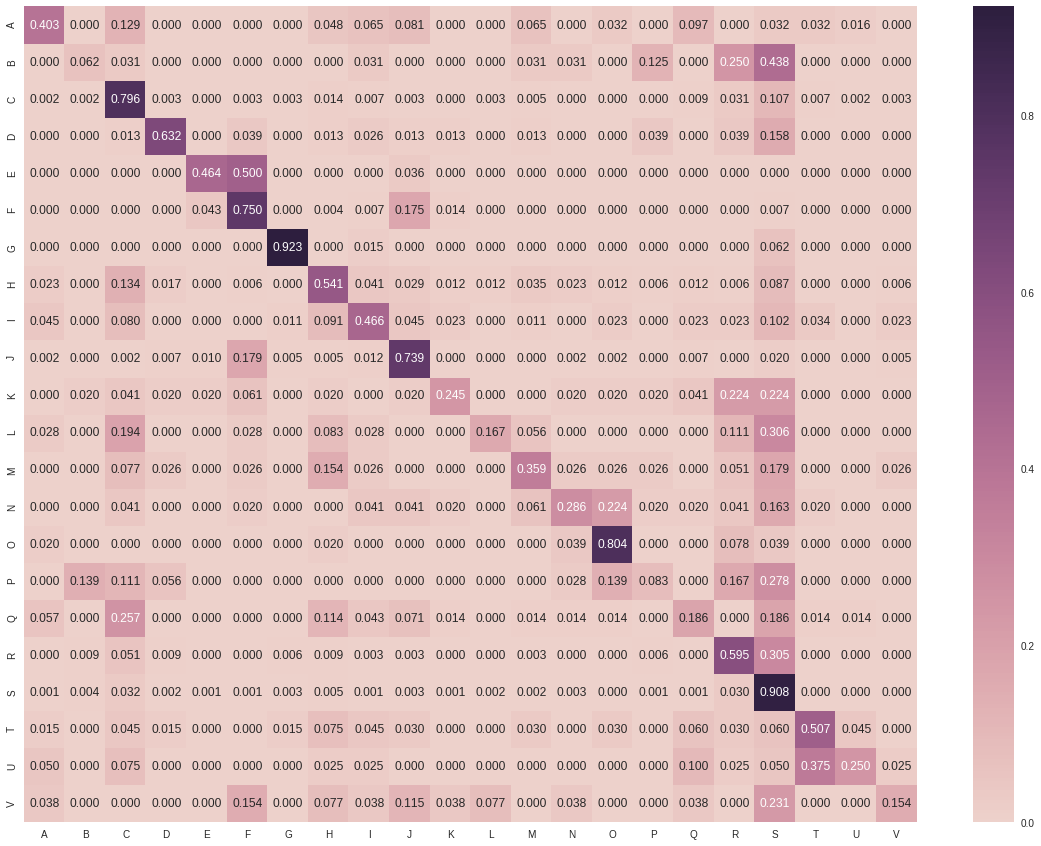

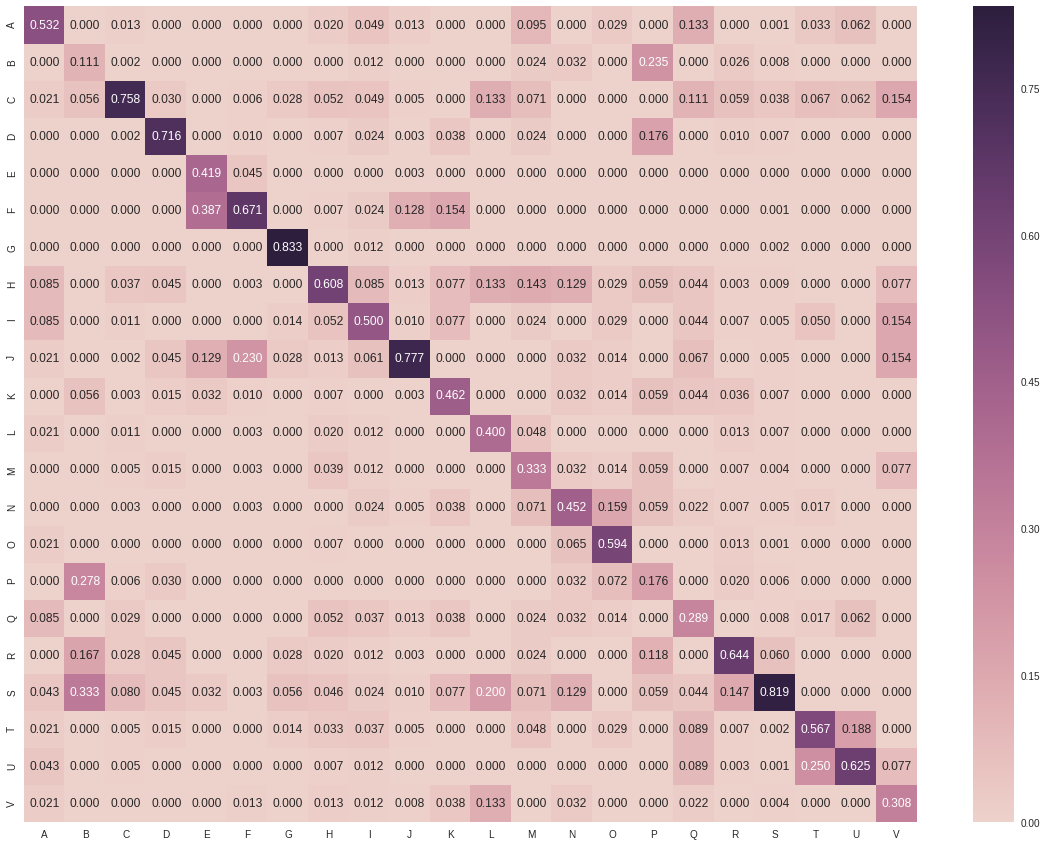

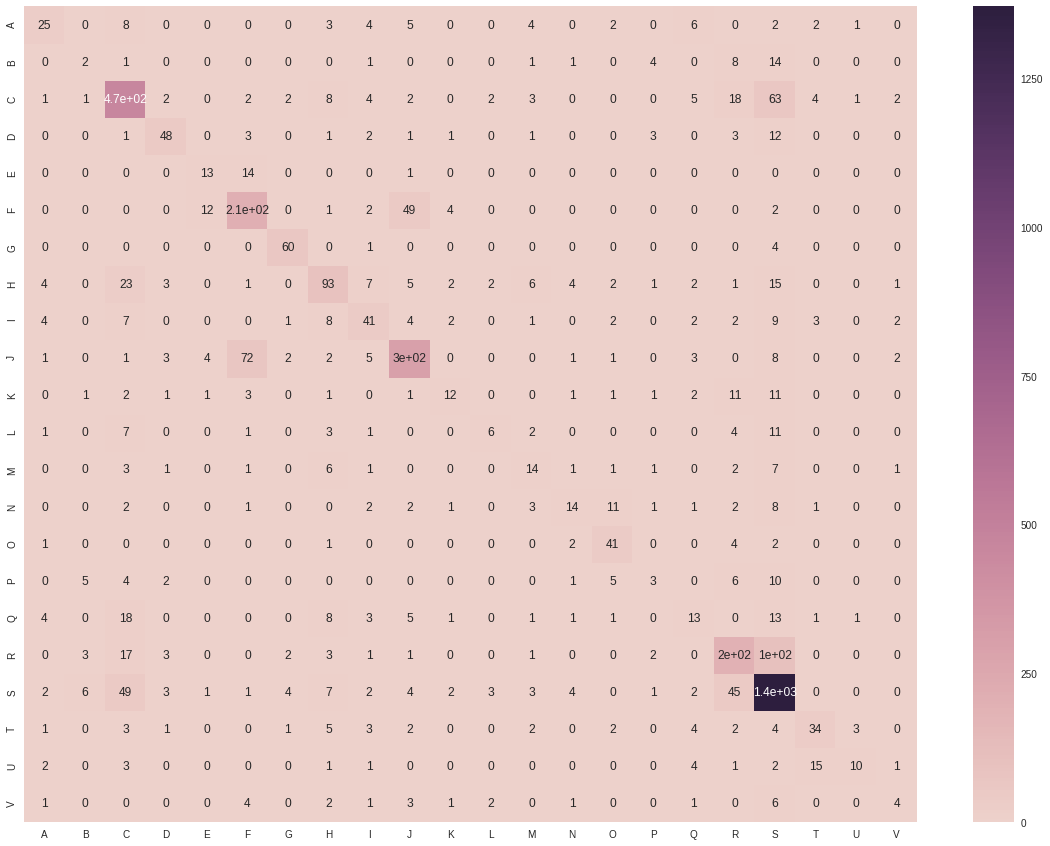

In [8]:
# Save minors
import pandas as pd
import seaborn as sn

V.put('cat_dic', cDic)
pickle.dump(conf_stack, open("{}/{}/{}_{}/confmat".format(os.getcwd(), "result", 
                                                      V.get('expTag'), V.get('expName')), 'wb'))
pickle.dump(V, open("{}/{}/{}_{}/information".format(os.getcwd(), "result", 
                                                      V.get('expTag'), V.get('expName')), 'wb'))

# Confusion matrix (column normalization)
conf_arr = test_conf
norm_conf = np.zeros((V.get('n_output'), V.get('n_output')))
for i in range(len(conf_arr)) :
    tmp_arr = conf_arr[i,:]
    a = np.sum(tmp_arr)
    if a != 0 :
        tmp_arr = tmp_arr.astype(np.float32)/a
    norm_conf[i,:] = tmp_arr
    
df_cm = pd.DataFrame(norm_conf, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"],
                     columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"])
plt.figure(figsize = (20,15))
cmap = sn.cubehelix_palette(8, as_cmap=True)
sn.heatmap(df_cm, annot=True, cmap=cmap, fmt='.3f')
plt.savefig("{}/{}/{}_{}/{}".format(os.getcwd(), "result", V.get('expTag'), V.get('expName'), "Conf_Col.png"))

# Confusion matrix (row normalization)
norm_conf = np.zeros((V.get('n_output'), V.get('n_output')))
for i in range(len(conf_arr)) :
    tmp_arr = conf_arr[:,i]
    a = np.sum(tmp_arr)
    if a != 0 :
        tmp_arr = tmp_arr.astype(np.float32)/a
    norm_conf[:,i] = tmp_arr
    
df_cm = pd.DataFrame(norm_conf, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"],
                     columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"])
plt.figure(figsize = (20,15))
cmap = sn.cubehelix_palette(8, as_cmap=True)
sn.heatmap(df_cm, annot=True, cmap=cmap, fmt='.3f')
plt.savefig("{}/{}/{}_{}/{}".format(os.getcwd(), "result", V.get('expTag'), V.get('expName'), "Conf_Row.png"))

# Confusion matrix (raw)
df_cm = pd.DataFrame(conf_arr.astype(int), index = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"],
                     columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"])
plt.figure(figsize = (20,15))
cmap = sn.cubehelix_palette(8, as_cmap=True)
sn.heatmap(df_cm, annot=True, cmap=cmap)
plt.savefig("{}/{}/{}_{}/{}".format(os.getcwd(), "result", V.get('expTag'), V.get('expName'), "Conf.png"))

In [9]:
# Remove records
os.system("rm -r -f {}/{}/{}".format(V.get('boardDir'), V.get('expTag'), V.get('expName')))
os.system("rm -r -f {}/{}/{}/{}".format(os.getcwd(), "result", V.get('expTag'), V.get('expName')))

0

In [17]:
tf.reset_default_graph()

In [18]:
sess.close()

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer/input_producer, input_producer/input_producer/RandomShuffle)]]


# Load Previous Model

In [6]:
# saver = tf.train.import_meta_graph("{}/{}.meta".format(V.get('model_save_path'), "save-57000"))
exp = "20170821_1007_256.512.512.512_e003"
saver = tf.train.import_meta_graph("{}/{}/{}/{}.meta".format("model", "CompactCNN", exp, "save-36000"))
# saver.restore(sess, tf.train.latest_checkpoint(V.get('model_save_path')))
saver.restore(sess, tf.train.latest_checkpoint("{}/{}/{}".format("model", "CompactCNN", exp)))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from model/CompactCNN/20170821_1007_256.512.512.512_e003/save-36000


INFO:tensorflow:Restoring parameters from model/CompactCNN/20170821_1007_256.512.512.512_e003/save-36000


# Visualization

In [40]:
for i in range(V.get('n_output')) :
    data = test_images_error1[i]
    labels = test_labels_error1[i]
    test_cost_err1 = 0
    test_acc_err1 = 0
    pred_arr = [0] * len(data)
    for j in range(len(data)) :
        test_acc_temp, test_cost_temp, test_pred = sess.run([acc_avg, loss_avg, pred_test], 
                                                 feed_dict={x:data[j], y:[labels[j]], 
                                                            phase:False, keep_prob:1, learning_rate:learning_rate_cur})
        test_cost_err1 += test_cost_temp
        test_acc_err1 += test_acc_temp
        pred_arr[j] = test_pred
    test_cost_err1 = test_cost_err1/float(len(data))
    test_acc_err1 = test_acc_err1/float(len(data))
    test_conf_err1 = sess.run(conf, feed_dict={y:labels, prediction:pred_arr})
    
    data = test_images_errorn[i]
    labels = test_labels_errorn[i]
    test_cost_errn = 0
    test_acc_errn = 0
    pred_arr = [0] * len(data)
    for j in range(len(data)) :
        test_acc_temp, test_cost_temp, test_pred = sess.run([acc_avg, loss_avg, pred_test], 
                                                 feed_dict={x:data[j], y:[labels[j]], 
                                                            phase:False, keep_prob:1, learning_rate:learning_rate_cur})
        test_cost_errn += test_cost_temp
        test_acc_errn += test_acc_temp
        pred_arr[j] = test_pred
    test_cost_errn = test_cost_errn/float(len(data))
    test_acc_errn = test_acc_errn/float(len(data))
    test_conf_err1 = sess.run(conf, feed_dict={y:labels, prediction:pred_arr})

#     recall    = np.diagonal(tools.confmat_normalize(V, test_conf, "row"))[np.newaxis]
#     precision = np.diagonal(tools.confmat_normalize(V, test_conf, "col"))[np.newaxis]
#     f1 = np.divide(2*(precision*recall), (precision+recall) + 0.0001)

    print "Class {:d}   [error1] test cost : {:.3f}  test acc : {:.3f}   [errorN] test cost : {:.3f}  test acc : {:.3f}".format(i, test_cost_err1, test_acc_err1, test_cost_errn, test_acc_errn)        

Class 0   [error1] test cost : 5.930  test acc : 0.213   [errorN] test cost : 4.259  test acc : 0.478
Class 1   [error1] test cost : 9.120  test acc : 0.194   [errorN] test cost : 11.696  test acc : 0.050
Class 2   [error1] test cost : 1.565  test acc : 0.700   [errorN] test cost : 2.384  test acc : 0.700
Class 3   [error1] test cost : 7.289  test acc : 0.231   [errorN] test cost : 0.758  test acc : 0.835
Class 4   [error1] test cost : 5.847  test acc : 0.500   [errorN] test cost : 4.276  test acc : 0.256
Class 5   [error1] test cost : 1.382  test acc : 0.720   [errorN] test cost : 2.027  test acc : 0.486
Class 6   [error1] test cost : 0.710  test acc : 0.889   [errorN] test cost : 1.031  test acc : 0.875
Class 7   [error1] test cost : 4.766  test acc : 0.380   [errorN] test cost : 2.864  test acc : 0.569
Class 8   [error1] test cost : 4.562  test acc : 0.330   [errorN] test cost : 4.766  test acc : 0.333
Class 9   [error1] test cost : 1.149  test acc : 0.710   [errorN] test cost : 1.5

In [46]:
for i in range(len(test_images_error1)) :
        print len(test_images_errorn[i])#, len(test_images_errorn[i])

23
20
70
85
43
70
32
72
36
28
42
10
62
57
73
34
10
100
100
63
36
10


In [44]:
print sorted(cDic.keys())

['ACT_HABU_PTN_ER', 'BLACK_IMUL', 'BLACK_SPOT', 'CNT_FILM', 'CNT_NOT_OPEN', 'CNT_NOT_OPEN_S', 'CORROSION', 'GAT1_HABU_PTN_E', 'GAT2_HABU_PTN_E', 'HOLE_PTN_ERR', 'ILD_FLAKE', 'LARVA', 'PAST_REPAIR', 'PI_UNDERLAYER', 'PI_UNDER_K', 'PI_UNDER_S', 'PTN_ERR', 'SD_BOMB', 'SD_SPOT', 'SHORT_D', 'SHORT_P', 'TI_YUSIL']


In [36]:
data = test_images_error1[i]
print len(data)

4


In [12]:
print recall

[[ 0.39795917  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]]


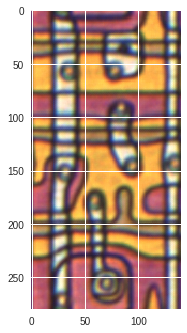

In [25]:
plt.imshow(ndimage.imread(f))

In [9]:
cell_xy_file = V.get('cell_xy_file')
cell_xy = pickle.load(open(cell_xy_file, 'rb'))

In [6]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)
test = []
for i in range(len(train_f_list)/64) :
    x_batch, y_batch = sess.run([train_image_batch, train_label_batch])
    test.extend(y_batch)

In [8]:
for i in range(22) :
    print test.count(i), train_l_list.count(i)

891 892
355 355
4395 4404
1151 1151
549 550
2177 2181
699 700
1799 1800
910 911
2963 2966
786 786
309 309
956 957
977 979
2184 2189
585 587
553 555
2844 2849
11570 11586
1043 1043
665 666
231 231


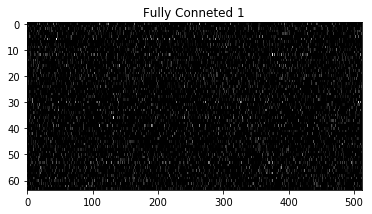

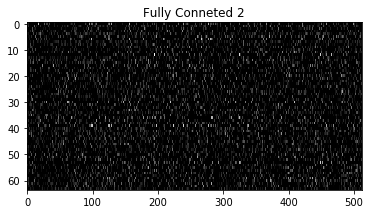

In [20]:
# Visualize activation
# train_image_batch, train_label_batch, train_xy_batch = pipeline(V, train_f_list, train_l_list, train_xy_list)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

graph = tf.get_default_graph()
layer1 = graph.get_tensor_by_name("FC1/fc1:0")
layer2 = graph.get_tensor_by_name("FC2/fc2:0")
x_batch, y_batch = sess.run([train_image_batch, train_label_batch])
x = graph.get_tensor_by_name("x_1:0")
phase = graph.get_tensor_by_name("phase_1:0")
keep_prob = graph.get_tensor_by_name("keep_prob_1:0")

features1, features2 = sess.run([layer1, layer2], feed_dict={x:x_batch, phase:False, keep_prob:1})
# plt.imshow(features[0,:,:,0], cmap='gray')
# features = features.reshape(features.shape[0], features.shape[1]*features.shape[2]*features.shape[3])
plt.figure()
plt.imshow(features1, cmap='gray', aspect=4)
plt.title("Fully Conneted 1")

plt.figure()
plt.imshow(features2, cmap='gray', aspect=4)
plt.title("Fully Conneted 2")

(3, 3, 3, 32)


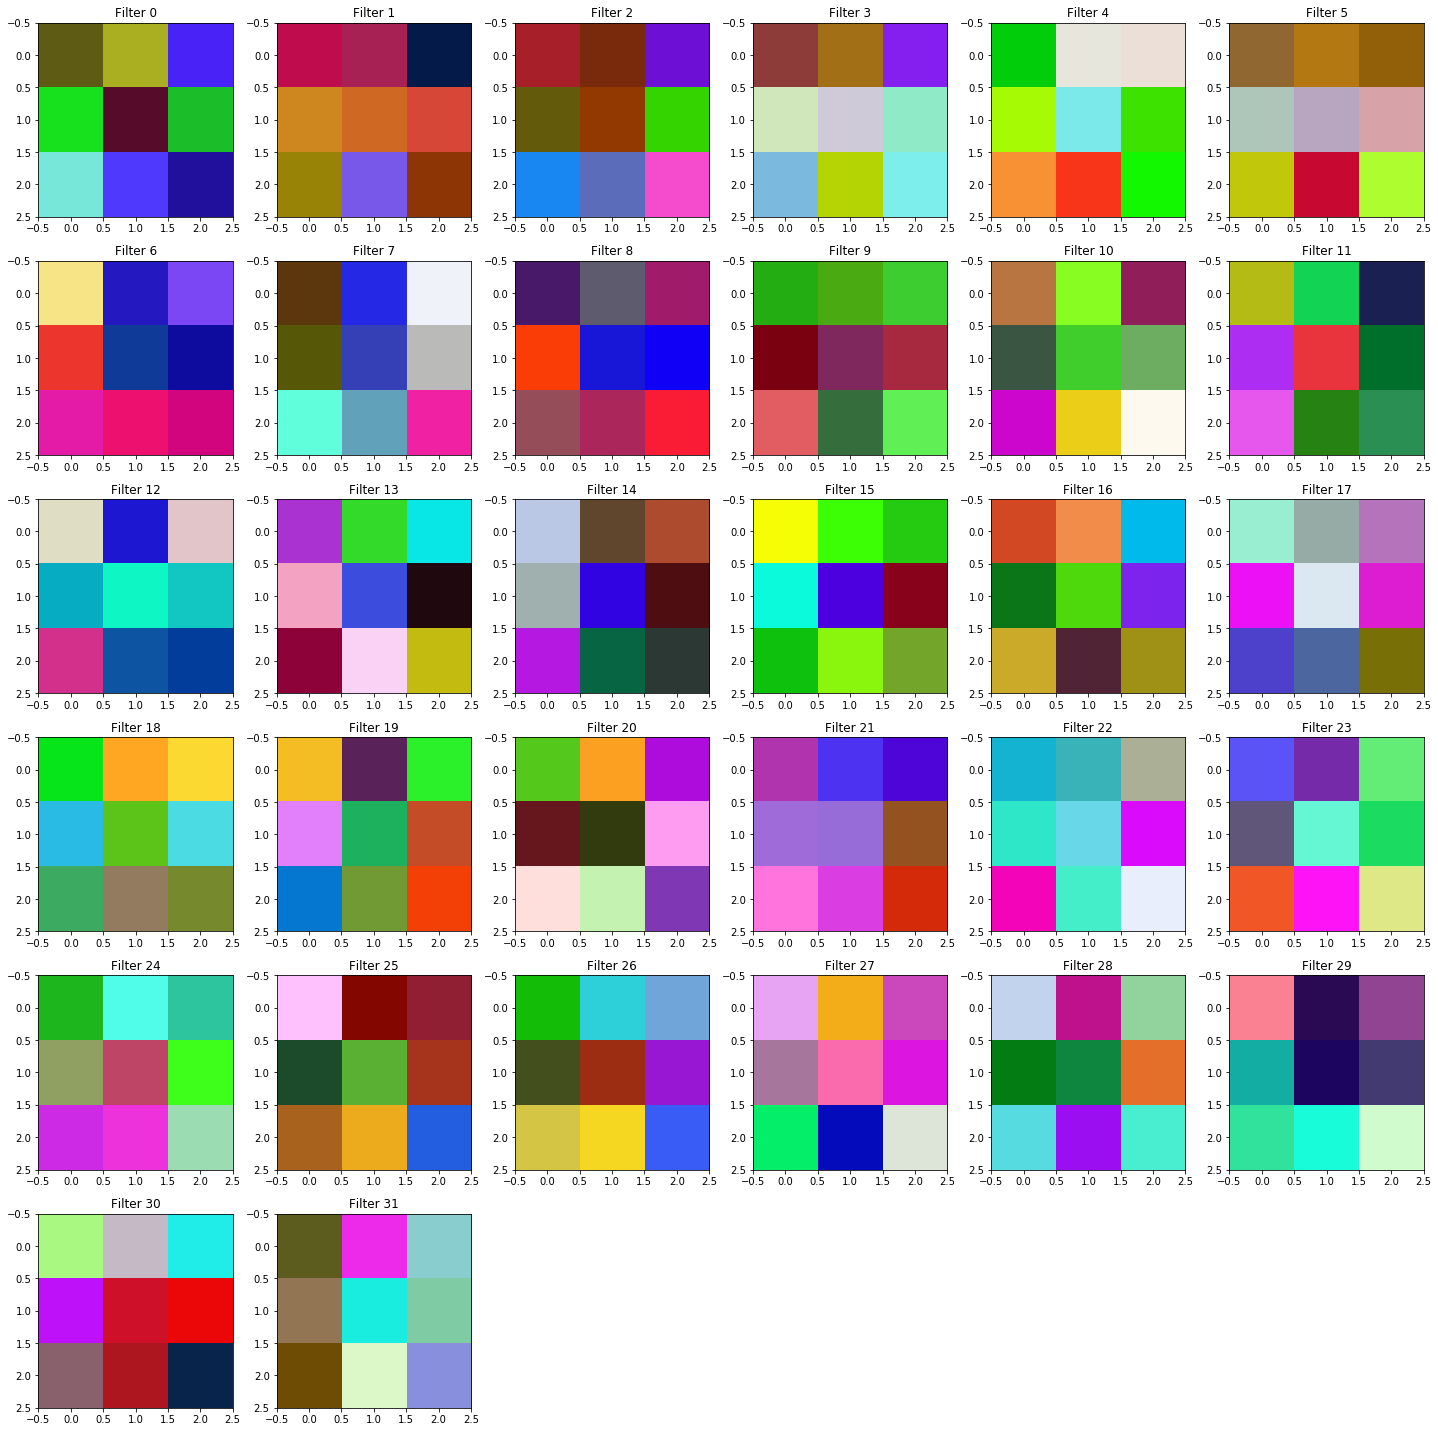

In [21]:
# Visualize filter weigth
graph = tf.get_default_graph()
w = graph.get_tensor_by_name("Weight/w_c1_1:0")
# x = np.zeros((280,140,3))
# cord = 
print w.shape
w = sess.run(w)
# plt.figure(1)
plotNNFilterRGB(w)
w = w[:,:,0,:]
# w = w.reshape(w.shape[0], w.shape[1], w.shape[2]*w.shape[3])
# plt.figure(2)
# plotNNFilter(w)
plt.tight_layout()

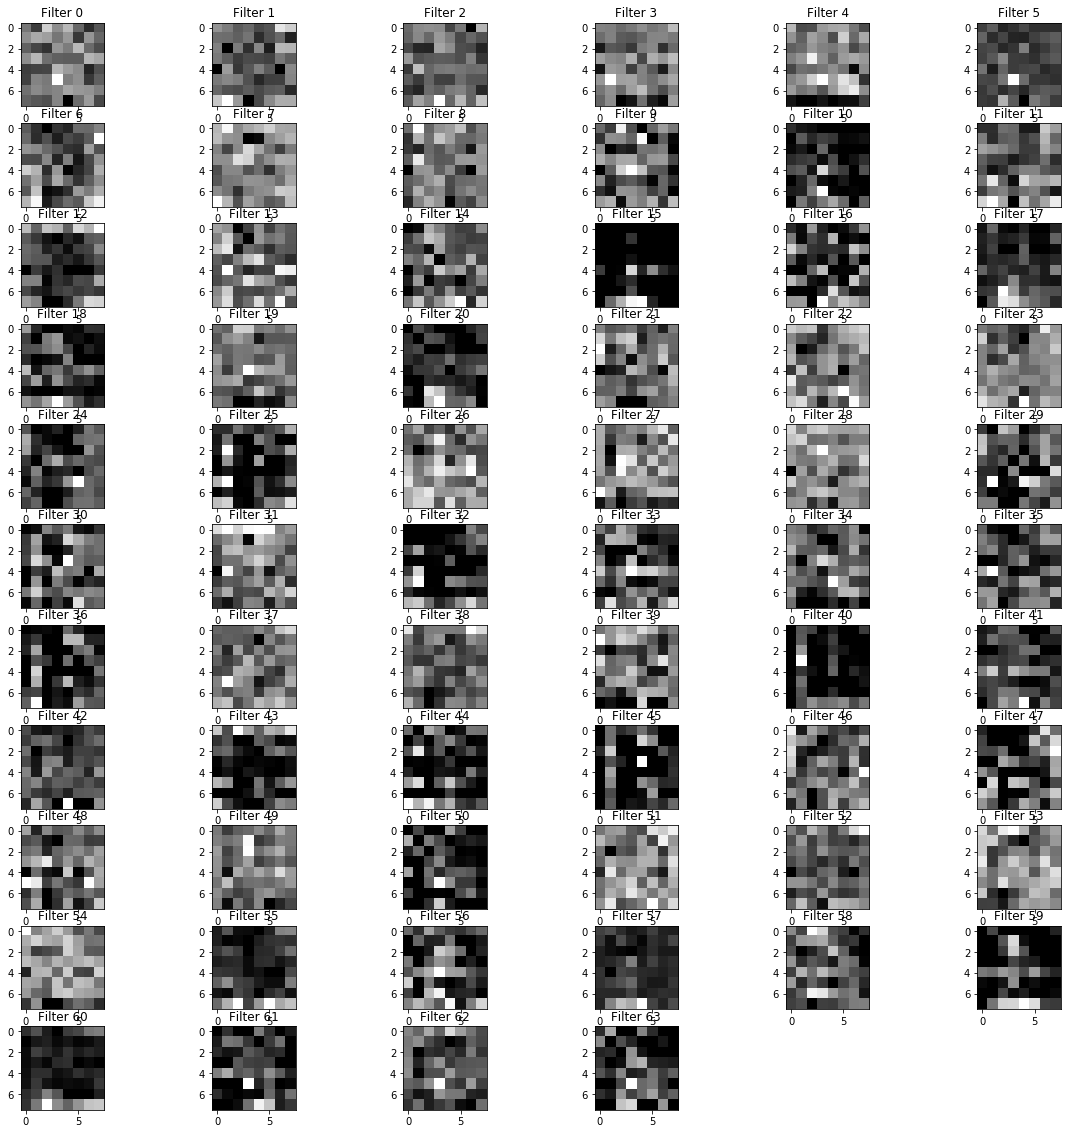

In [26]:
# VIsualize filter output
graph = tf.get_default_graph()
conv1 = graph.get_tensor_by_name("Conv2/pool2:0")
x_batch, y_batch = sess.run([train_image_batch, train_label_batch])

features1 = sess.run(conv1, feed_dict={x:x_batch, phase:False, keep_prob:1})
# plt.imshow(features[0,:,:,0], cmap='gray')
# features = features.reshape(features.shape[0], features.shape[1]*features.shape[2]*features.shape[3])
# filter_id = np.random.randint(features1.shape[3])
# features1 = features1[:36,:,:,filter_id]
# plotNNOutput(features1)
image_id = np.random.randint(features1.shape[0])
features1 = features1[image_id,:,:,:]
plotNNFilter(features1)

In [26]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

x_batch, y_batch, cord_batch = sess.run([train_image_batch, train_label_batch, train_xy_batch])
a = sess.run(cord_grid, feed_dict={cord:cord_batch})
print a.shape
print y_batch
for i in range(22) :
    print y_batch.tolist().count(i), train_l_list.count(i)

(64, 11)
[15  9 13 11 18  2  8  8  0 19  8  7  2  2  3 19  9  3  2  7 18  7  9  5  2
 21 12 20 17 11  6  4 15 21 10 19 18  3 16  7  7  8 21 21  9 19 21  2 18 11
  7 16 21 15 14 20  8  4 15  9 14  3  1 20]
1 5904
1 5976
6 5634
4 5733
2 5440
1 5508
1 2989
6 11952
5 5535
5 5790
1 5478
3 4972
1 5803
1 4338
2 5966
4 5690
2 5928
1 3021
4 4578
4 5590
3 4530
6 5700


In [ ]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

x_batch, y_batch = sess.run([train_image_batch, train_label_batch])
# y_batch = sess.run([train_label_batch])
result = sess.run(x_std, feed_dict={x:x_batch})
print plt.imshow(result[3].astype(np.uint8))

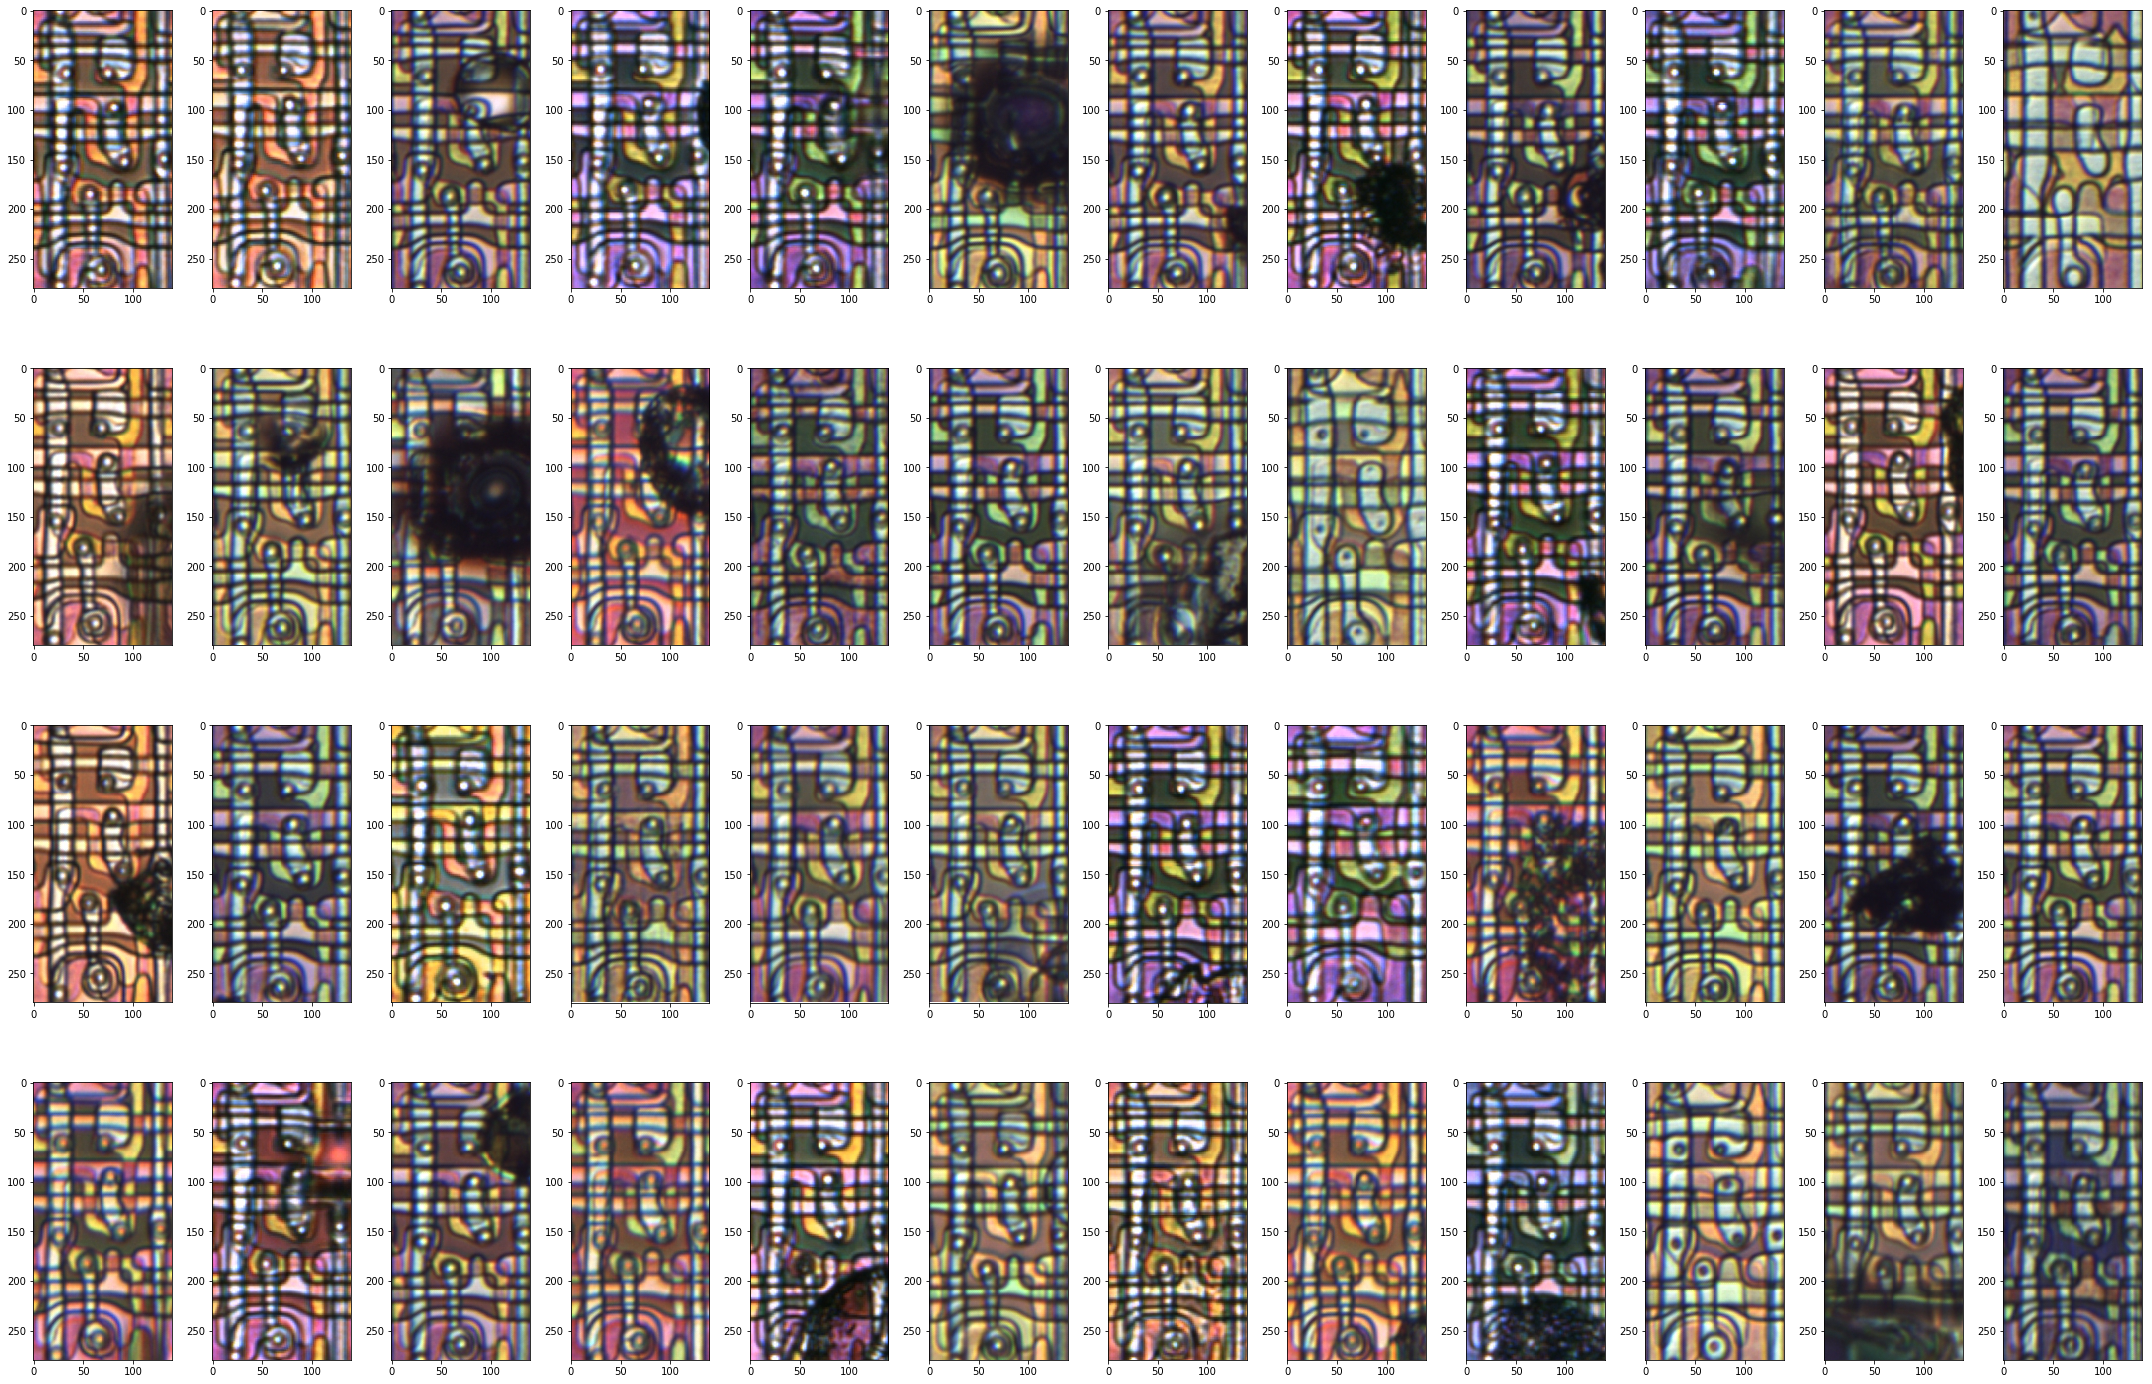

In [6]:
# visualize
visual_cat = "PI_UNDER_K"
fig, ax = plt.subplots(4, 12, figsize=(30, 20))
idxs = np.random.permutation(len(fList))
m = 0
for i in range(4):
    for j in range(12):
        while(cList[idxs[m]] != cDic[visual_cat]) :
            m += 1
#         n = 12*i + j
        f = fList[idxs[m]][0]
#         print cList[idxs[n]]
        ax[i,j].imshow(ndimage.imread(f))
        m += 1
plt.tight_layout()

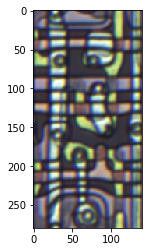

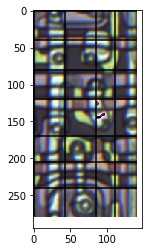

In [77]:
# visualize griding
i = np.random.randint(len(fList))
f = fList[i][0]
xy = xyList[i][0]
# x_grid_std = range(0,141,20)
# x_grid_std = [0, 18, 42, 58, 82, 110, 140]
x_grid_std = [0, 42, 85, 110, 140]
# y_grid_std = range(0,281,20)
y_grid_std = [0, 40, 80, 120, 170, 205, 240, 280]
img = ndimage.imread(f)
plt.figure(1)
plt.imshow(img)
img[y_grid_std[xy[0]]:y_grid_std[xy[0]+1], x_grid_std[xy[1]]:x_grid_std[xy[1]+1], :] += 20
plt.figure(2)
plt.imshow(img)
for std in x_grid_std[:-1] :
    plt.vlines(std, 0, 280)
for std in y_grid_std[:-1] :
    plt.hlines(std, 0, 140)

In [36]:
cnt = np.zeros(70, dtype=np.int32)
test_a = 0
test_b = 0
for i in range(test_set_size) :
    l = len(test_images[i])
    cnt[l] += 1*l
    test_a += 1
print cnt
print np.sum(cnt[2:])

[   0 2415  930  225  228   95   90   56   24    0   60   11    0    0   14
    0   16   17    0    0    0    0    0    0    0    0   26    0    0    0
   30    0    0    0    0   35    0   37    0    0    0   41    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
1935


# ETC 

In [15]:
%%writefile structure.py
# Some Structure Function
import tensorflow as tf
# def conv3(layer_in, w, b, do_bn, phase, name, momentum=0.99) :
#     conv = tf.nn.conv2d(layer_in, w, strides=[1,1,1,1], padding='SAME')
#     conv = tf.nn.bias_add(conv, b)
#     if do_bn :
#         conv = tf.layers.batch_normalization(conv, axis=3, center=True, scale=True, training=phase, momentum=momentum)
#     relu = tf.nn.relu(conv, name=name)
#     tf.summary.histogram("weights", w)
#     tf.summary.histogram("bias", b)
#     tf.summary.histogram("layer", conv)
#     tf.summary.histogram("activations", relu)
#     return relu

def conv_univ(layer_in, W, B, S, N, phase, name_scope, momentum=0.99, do_bn=False, do_histogram=False) :
    with tf.name_scope(name_scope) :
        conv = layer_in
        for i in range(len(W)) :
            conv = tf.nn.conv2d(conv, W[i], strides=S[i], padding='SAME')
            conv = tf.nn.bias_add(conv, B[i])
            if do_bn :
                conv = tf.layers.batch_normalization(conv, axis=3, center=True, scale=True, training=phase, momentum=momentum)
            conv = tf.nn.relu(conv, name=N[i])
            if do_histogram :
                tf.summary.histogram("weights", W[i])
                tf.summary.histogram("bias", B[i])
                tf.summary.histogram("activations", conv)

        # pooling
        pool = tf.nn.max_pool(conv, ksize=S[-1], strides=S[-1], padding='SAME', name=N[-1])
    return pool

def fc_univ(layer_in, w, b, n, phase, name_scope, keep_prob=None, momentum=0.99, do_bn=False, do_do=False, do_histogram=False) :
    with tf.name_scope(name_scope) :
        fc = tf.nn.bias_add(tf.matmul(layer_in, w), b)
        if do_bn :
            fc = tf.layers.batch_normalization(fc, axis=1, center=True, scale=True, training=phase, momentum=momentum)
        fc = tf.nn.relu(fc, name=n)
        if do_histogram :
            tf.summary.histogram("weights", w)
            tf.summary.histogram("bias", b)
            tf.summary.histogram("activations", fc)
        if do_do :
            fc = tf.nn.dropout(fc, keep_prob)
    return fc

# def conv33pool2(layer_in, w1, b1, w2, b2, phase, keep_prob, l1_name, l2_name, p_name, name_scope, do_bn=False) :
#     with tf.name_scope(name_scope) :
#         layer1 = conv3(layer_in, w1, b1, do_bn, phase, l1_name)
#         layer2 = conv3(layer1, w2, b2, do_bn, phase, l2_name)
#         pool = tf.nn.max_pool(layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=p_name)
# #         pool = tf.nn.dropout(pool, keep_prob)
#     return pool

# def conv33pool4(layer_in, w1, b1, w2, b2, phase, keep_prob, l1_name, l2_name, p_name, name_scope, do_bn=False) :
#     with tf.name_scope(name_scope) :
#         layer1 = conv3(layer_in, w1, b1, do_bn, phase, l1_name)
#         layer2 = conv3(layer1, w2, b2, do_bn, phase, l2_name)
#         pool = tf.nn.max_pool(layer2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME', name=p_name)
# #         pool = tf.nn.dropout(pool, keep_prob)
#     return pool

# def conv333pool2(layer_in, w1, b1, w2, b2, phase, name_scope) :
#     with tf.name_scope(name_scope) :
#         layer1 = conv3_bn(layer_in, w1, b1, phase)
#         layer2 = conv3_bn(layer1, w2, b2, phase)
#         layer3 = conv3_bn(layer2, w3, b3, phase)
#         pool = tf.nn.max_pool(layer3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
#     return pool

# def conv333pool5(layer_in, w1, b1, w2, b2, w3, b3, phase, name_scope) :
#     with tf.name_scope(name_scope) :
#         layer1 = conv3_bn(layer_in, w1, b1, phase)
#         layer2 = conv3_bn(layer1, w2, b2, phase)
#         layer3 = conv3_bn(layer2, w3, b3, phase)
#         pool = tf.nn.max_pool(layer3, ksize=[1,5,5,1], strides=[1,5,5,1], padding='SAME')
#     return pool

# def conv3pool_half(layer_in, w, b, phase, name_scope) :
#     with tf.name_scope(name_scope) :
#         layer1 = conv3_bn(layer_in, w, b, phase)
#         pool = tf.nn.max_pool(layer1, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
#     return pool

Overwriting structure.py


In [8]:
%%writefile tools.py
import os
import itertools
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import glob
from scipy import ndimage

class Vars() :
    def __init__(self) :
        self.handler = {}
        
    def get(self, key) :
        return self.handler[key]
    
    def put(self, key, value) :
        self.handler[key] = value
        
        
def load_image(f) :
    return ndimage.imread(f)

def load_data_cell(V, rm_list, x_grid_std, y_grid_std) :
    # load Data
    data_dir = V.get('data_dir')
    cell_xy_file = V.get('cell_xy_file')
    cats = os.listdir(data_dir)
    for c in cats :
        if not filter(os.path.isdir, glob.glob("{}/{}".format(data_dir, c))) :
             cats.remove(c)
    for rm in rm_list :
        cats.remove(rm)
    cats = sorted(cats)
    print "Classes :"
    print cats

    cell_xy = pickle.load(open(cell_xy_file, 'rb'))
    fList = []
    cList = []
    xyList = []
    cDic = { cats[i] : i for i in range(len(cats)) }
    for c in cats :
        fCat = os.listdir("{}/{}".format(data_dir, c))
        fCat = sorted(fCat, key=str.lower)
        f_check = fCat[0].split("_")[0]
        f_arr = []
        xy_arr = []
        for f in fCat :
            tokens = f.split("_")
            if tokens[0] != f_check :
                f_check = tokens[0]
                fList.append(f_arr)
                xyList.append(xy_arr)
                cList.append(cDic[c])
                f_arr = []
                xy_arr = []
            f_name = "{}/{}/{}".format(data_dir, c, f)
            f_key = "{}/{}/{}".format("/notebooks/sd/../cell_unscale", c, f)
            f_arr.append(f_name)
            if f_key in cell_xy :
                xy = list(cell_xy[f_key])
                for i in range(len(x_grid_std)-1) :
                    if x_grid_std[i] <= xy[1] < x_grid_std[i+1] :
                        xy[1] = i
                        break
                for i in range(len(y_grid_std)-1) :
                    if y_grid_std[i] <= xy[0] < y_grid_std[i+1] :
                        xy[0] = i
                        break
                xy_arr.append(xy)
        fList.append(f_arr)
        cList.append(cDic[c])
        xyList.append(xy_arr)

    V.put('n_output', len(cDic))
    print "# of class : {:d}".format(len(cDic))
    print "# of images : {:d}".format(len(fList))
    print "# of cells : {:d}".format(len(list(itertools.chain.from_iterable(fList))))
    print "Loading Done"
    return [fList, cList, xyList, cDic]

def partition(V, fList, cList, xyList, cDic) :
    test_set_size = V.get('test_set_size')
    train_set_size = len(fList) - test_set_size
    V.put("train_set_size", train_set_size)
    partitions = np.random.permutation(len(fList))
    train_f_list = []
    train_l_list = []
    train_xy_list = []
    for p in partitions[:train_set_size] :
        train_f_list.extend(fList[p])
        train_l_list.extend([cList[p] for i in range(len(fList[p]))])
        train_xy_list.extend(xyList[p])
    print "# of train cells : {:d}".format(len(train_f_list))
    print "Train partition done"
    test_f_list = []
    test_labels = []
    test_xys = []
    for p in partitions[train_set_size:] :
        test_f_list.append(fList[p])
        test_labels.append(cList[p])
        test_xys.append(xyList[p])
    test_images = []
    for fs in test_f_list :
        imgs = []
        for f in fs :
            imgs.append(ndimage.imread(f))
        test_images.append(np.array(imgs))
    print "Test partition done"
    return [train_f_list, train_l_list, train_xy_list, test_images, test_labels, test_xys]

def oversampling(train_f_list, train_l_list, cDic) :
    n_max = 0
    l_max = 0
    n_list = np.zeros(len(cDic))
    for i in range(len(cDic)) :
        n = train_l_list.count(i)
        n_list[i] = n
        if n > n_max :
            n_max = n
            l_max = i

    ratio_base = 0.9
    ratio_list = (n_max / n_list * ratio_base - 1)
    new_train_f_list = train_f_list[:]
    new_train_l_list = train_l_list[:]
    for i in range(len(train_l_list)) :
        r_float, r_int = math.modf(ratio_list[train_l_list[i]])
        new_train_f_list.extend([train_f_list[i]] * int(r_int))
        new_train_l_list.extend([train_l_list[i]] * int(r_int))
    #         train_xy_list.extend([train_xy_list[i]] * int(r_int))
        nexon = np.random.random()
        if nexon < r_float :
            new_train_f_list.extend([train_f_list[i]])
            new_train_l_list.extend([train_l_list[i]])
    #             train_xy_list.extend([train_xy_list[i]])

    # permutation
    perm = np.random.permutation(len(new_train_f_list))
    new_train_f_list = [ new_train_f_list[p] for p in perm ]
    new_train_l_list = [ new_train_l_list[p] for p in perm ]
    #     new_train_xy_list = [ train_xy_list[p] for p in perm ]

    print "# of data after oversampling : {:d}".format(len(new_train_f_list))
    n_list = np.zeros(len(cDic))
    for i in range(len(cDic)) :
        n_list[i] = new_train_l_list.count(i)
    print n_list
    return new_train_f_list, new_train_l_list

def undersampling(train_f_list, train_l_list, cDic) :
    n_max = 0
    l_max = 0
    n_list = np.zeros(len(cDic))
    for i in range(len(cDic)) :
        n = train_l_list.count(i)
        n_list[i] = n
        if n > n_max :
            n_max = n
            l_max = i
    
    ratio_base = 0.6
    new_train_f_list = []
    new_train_l_list = []
    for i in range(len(train_l_list)) :
        if train_l_list[i] != l_max :
            new_train_f_list.append(train_f_list[i])
            new_train_l_list.append(train_l_list[i])
        else :
            nexon = np.random.random()
            if nexon < ratio_base :
                new_train_f_list.append(train_f_list[i])
                new_train_l_list.append(train_l_list[i])
                
    # permutation
    perm = np.random.permutation(len(new_train_f_list))
    new_train_f_list = [ new_train_f_list[p] for p in perm ]
    new_train_l_list = [ new_train_l_list[p] for p in perm ]
            
    print "# of data after undersampling : {:d}".format(len(new_train_f_list))
    n_list = np.zeros(len(cDic))
    for i in range(len(cDic)) :
        n_list[i] = new_train_l_list.count(i)
    print n_list
    return new_train_f_list, new_train_l_list

def pipeline_train(V, train_f_list, train_l_list, train_xy_list=None) :
# build pipeline
    cell_x = V.get('cell_x')
    cell_y = V.get('cell_y')
    batch_size = V.get('batch_size')
#     test_set_size = V.get('test_set_size')
#     train_set_size = V.get('train_set_size')
    n_input = cell_y*cell_x
    n_output = V.get('n_output')
    if train_xy_list != None :
        do_xy = True
    else :
        do_xy = False
    
    train_images = tf.convert_to_tensor(train_f_list, dtype=tf.string)
    train_labels = tf.convert_to_tensor(train_l_list, dtype=tf.uint8)
    if do_xy :
        train_xys = tf.convert_to_tensor(train_xy_list)

    if do_xy :
        train_input_queue = tf.train.slice_input_producer([train_images, train_labels, train_xys], shuffle=True)
    else :
        train_input_queue = tf.train.slice_input_producer([train_images, train_labels], shuffle=True)

    file_content = tf.read_file(train_input_queue[0])
    train_image = tf.image.decode_png(file_content)
    train_image.set_shape([cell_y, cell_x, 3])
    train_label = train_input_queue[1]
    if do_xy :
        train_xy = train_input_queue[2]
    
    if do_xy :
        batch_out = tf.train.batch([train_image, train_label, train_xy], batch_size = batch_size)
    else :
        batch_out = tf.train.batch([train_image, train_label], batch_size = batch_size)

    print "Batching done"
    return batch_out

def resize(V, x) :
    # preprocessing
    with tf.name_scope("Resize") :
        x_resize = tf.image.resize_images(x, [V.get('size_re'), V.get('size_re')])
    return x_resize

def zero_channel(V, x) :
    with tf.name_scope("Zero_Channel") :
        ch_mean = tf.reduce_mean(x, [1,2])
        ch_mean = tf.expand_dims(ch_mean, 1)
        ch_mean = tf.expand_dims(ch_mean, 2)
        ch_mean = tf.tile(ch_mean, [1, V.get('size_re'), V.get('size_re'), 1])
        x_std = x - ch_mean
    return x_std

def confmat_normalize(V, conf_arr, mode) :
    norm_conf = np.zeros((V.get('n_output'), V.get('n_output')))
    if mode == "row" :
        for i in range(len(conf_arr)) :
            tmp_arr = conf_arr[i,:]
            a = np.sum(tmp_arr)
            if a != 0 :
                tmp_arr = tmp_arr.astype(np.float32)/a
            norm_conf[i,:] = tmp_arr
    if mode == "col" :
        for i in range(len(conf_arr)) :
            tmp_arr = conf_arr[:,i]
            a = np.sum(tmp_arr)
            if a != 0 :
                tmp_arr = tmp_arr.astype(np.float32)/a
            norm_conf[:,i] = tmp_arr
    return norm_conf

def plotNNFilter(units):
    filters = units.shape[2]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[:,:,i], interpolation="nearest", cmap="gray")
        
def plotNNFilterRGB(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[:,:,:,i], interpolation="nearest")
        
def plotNNOutput(units):
    n_images = units.shape[0]
    plt.figure(1, figsize=(15,15))
    plt.axis('off')
    n_columns = 6
    n_rows = math.ceil(n_images / n_columns) + 1
    for i in range(n_images):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Image ' + str(i))
        plt.imshow(units[i,:,:], interpolation="nearest", cmap="gray")
        
def make_recorder(V, result_dir) :
    with tf.name_scope("Cost") :
        train_loss = tf.placeholder(tf.float32, shape=(), name="train_loss")
        test_loss = tf.placeholder(tf.float32, shape=(), name="test_loss")
        tf.summary.scalar("test_loss", test_loss)
        tf.summary.scalar("train_loss", train_loss)
    with tf.name_scope("Accuracy") :
        train_accuracy = tf.placeholder(tf.float32, shape=(), name="train_accuracy")
        test_accuracy = tf.placeholder(tf.float32, shape=(), name="test_accuracy")
        tf.summary.scalar("train_accuracy", train_accuracy)
        tf.summary.scalar("test_accuracy", test_accuracy)
        
    if not os.path.exists(result_dir) :
        os.makedirs(result_dir)
    rec_writer = open("{}/recall.txt".format(result_dir), 'w')
    prec_writer = open("{}/precision.txt".format(result_dir), 'w')
    f1_writer = open("{}/f1.txt".format(result_dir), 'w')
    conf_stack = np.zeros((V.get('n_output'), V.get('n_output'), 0))
    return train_loss, test_loss, train_accuracy, test_accuracy, rec_writer, prec_writer, f1_writer, conf_stack

def record(rec_writer, recall, prec_writer, precision, f1_writer, f1, step) :
    rec_writer.write("{:d} ".format(step))
    np.savetxt(rec_writer, recall, fmt='%0.3f')
    prec_writer.write("{:d} ".format(step))
    np.savetxt(prec_writer, precision, fmt='%0.3f')
    f1_writer.write("{:d} ".format(step))
    np.savetxt(f1_writer, f1, fmt='%0.3f')
    rec_writer.flush()
    prec_writer.flush()
    f1_writer.flush()

Overwriting tools.py
